In [1]:
import re
import warnings
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from datetime import datetime
from IPython.display import Image

In [2]:
warnings.filterwarnings("ignore")

# Overview

This Exploratory Data Analysis will focus on obtaining insights of high-value loyal customers i.e. customers that make large purchases and repeated orders while using Olist. 

The data cleaning process is elaborated more in the annex's preliminary _data_analysis notebook. Refer to it for more information of how it is cleaned.

**Driving Questions**: 
- Who are the customers returning to Olist?
- What do returning customers depend on Olist for? 
- When do customers return to Olist for products?
- Where do returning customers reside?
- Why do returning customers favour Olist?

# Assumptions
The assumptions made in this EDA.

1) The cities in the customers dataset is the correct spelling and the zip codes, cities and states correctly correspond to one another.
2) Customers who have made more than 1 order on Olist has done so because they are loyal appreciated the service/value Olist provided and not due to other factors, such as sudden sales.
3) Customers who have higher average spending on Olist have greater disposable income.
4) Review scores accurately represent the customers' satisfaction with the order.

# Data Loading
Load the datasets using pandas

In [3]:
# Load the customers dataset
customers_df = pd.read_csv(
    "./data/02_processed/cleaned_customers_dataset.csv",
    converters={
        'customer_zip_code_prefix': str # Convert ZIP codes to strings
    }
)
customers_df.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,09790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,01151,sao paulo,SP


In [4]:
# Load the geolocation dataset
geolocation_df = pd.read_csv(
    "./data/02_processed/cleaned_geolocation_dataset.csv",
    converters={
        'geolocation_zip_code_prefix': str # Convert ZIP codes to strings
    }
)
geolocation_df.head(3)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,01001,-23.549951,-46.634027,sao paulo,SP
1,01002,-23.548228,-46.635247,sao paulo,SP
2,01003,-23.548977,-46.635313,sao paulo,SP


In [5]:
# Load the order items dataset
items_df = pd.read_csv("./data/01_raw/olist_order_items_dataset.csv")
items_df.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


In [6]:
# Load the payments dataset
payments_df = pd.read_csv("./data/01_raw/olist_order_payments_dataset.csv")
payments_df.head(3)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71


In [7]:
# Load the reviews dataset
reviews_df = pd.read_csv("./data/02_processed/cleaned_order_reviews_dataset.csv")
reviews_df.head(3)

,review_id,order_id,review_score,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,2018-02-17 00:00:00,2018-02-18 14:36:24


In [8]:
# Load the orders dataset
orders_df = pd.read_csv("./data/02_processed/cleaned_orders_dataset.csv")
orders_df.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04 00:00:00


In [9]:
# Load the products dataset
products_df = pd.read_csv("./data/02_processed/cleaned_products_dataset.csv")
products_df.head(3)

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_id,product_category_name
0,40.0,287.0,1.0,225.0,16.0,10.0,14.0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria
1,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,3aa071139cb16b67ca9e5dea641aaa2f,artes
2,46.0,250.0,1.0,154.0,18.0,9.0,15.0,96bd76ec8810374ed1b65e291975717f,esporte_lazer


In [10]:
# Load the sellers dataset
sellers_df = pd.read_csv(
    "./data/02_processed/cleaned_sellers_dataset.csv",
    converters={
        'seller_zip_code_prefix': str # Convert ZIP codes to strings
    }
)
sellers_df.head(3)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi-guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ


In [11]:
# Load the product category name translation dataset
translations_df = pd.read_csv("./data/01_raw/product_category_name_translation.csv")
translations_df.head(3)

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto


# Preprocessing
Perform data cleaning, feature selection and feature engineering for downstream EDA.

# Returning Customer Rate
Measure Olist's customer retention.

In [12]:
# Identify the number of orders by each customer
customer_order_count = customers_df['customer_unique_id'].value_counts()

# Create a boolean series for customers who have more than 1 order
repeated_customers = customer_order_count > 1

# Label customers with more than 1 order as a returning customer in a Dataframe
repeated_customers_df = pd.DataFrame({
    'order_count': customer_order_count,
    'is_repeated_customer': repeated_customers
}).reset_index()

repeated_customers_df

,customer_unique_id,order_count,is_repeated_customer
0,8d50f5eadf50201ccdcedfb9e2ac8455,17,True
1,3e43e6105506432c953e165fb2acf44c,9,True
2,6469f99c1f9dfae7733b25662e7f1782,7,True
3,ca77025e7201e3b30c44b472ff346268,7,True
4,1b6c7548a2a1f9037c1fd3ddfed95f33,7,True
...,...,...,...
96091,e18e1db417f0bc97f9065c4aeae3f9d3,1,False
96092,3c8d75c7b0acfda04e92d3dca43ccee7,1,False
96093,10674cc49bd68773d186d496d8ed071d,1,False
96094,e097d846931763789c3fd00b27f3c325,1,False


In [13]:
# Calculate the number of returning customers
repeated_customers_count = repeated_customers_df['is_repeated_customer'].sum()
print(f"Number of returning customers: {repeated_customers_count}")

# Calculate the proportion of repeated and non-repeated customers
repeated_customers_proportion = repeated_customers_df['is_repeated_customer'].value_counts(normalize=True) * 100

# Reset index to make it a DataFrame
repeated_customers_proportion_df = repeated_customers_proportion.reset_index()
repeated_customers_proportion_df.columns = ['is_repeated_customer', 'proportion']

# Round the proportions to 2dp
repeated_customers_proportion_df['proportion'] = round(repeated_customers_proportion_df['proportion'], 2)

repeated_customers_proportion_df

Number of returning customers: 2997


,is_repeated_customer,proportion
0,False,96.88
1,True,3.12


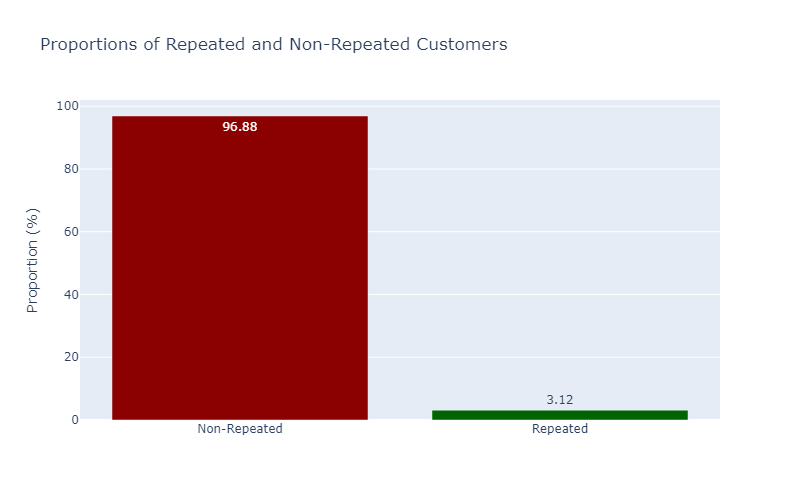

In [14]:
# Create a bar graph to showcase the proportions
fig = px.bar(
    repeated_customers_proportion_df,
    x='is_repeated_customer',
    y='proportion',
    text='proportion',
    color='is_repeated_customer',
    labels={'proportion': 'Proportion (%)'},
    title='Proportions of Repeated and Non-Repeated Customers',
    color_discrete_map={False: 'darkred', True: 'darkgreen'}
)

# Hide the x-axis and change the category names
fig.update_layout(
    xaxis=dict(
        tickvals=[0, 1],  # Set custom tick values 
        ticktext=['Non-Repeated', 'Repeated'],  # Custom category names
        title=None  # Hide the x-axis title
    ),
    showlegend=False  # Hide the legend
)

# Show the plot
image_bytes = fig.to_image(format='png', width=800)
Image(image_bytes)


**Findings**:
- Only 2997 of the 96096 customers from 2016 to 2018, are repeated customers. 
- This is only about 3.12% of the total customers from 2016 to 2018.
- This proportion is very small and the insights obtained will be prone to noise in the dataset.

# Delivery Efficiency
Investigates if delivery efficiency contributes to customers returning to Olist.

In [15]:
# Identify the offset between 2 dates
def date_difference(row: pd.Series, start: str, end:str) -> int:
    """
    Calculate the difference in days between two dates.

    Parameters:
        row (pd.Series): The row from the dataset.

    Returns:
        int: The difference in days between the two dates. 
        Negative values represent early deliveries.
        Positive values represent late deliveries
    """
    try:
        # Identify the 2 dates
        date1 = row[start]
        date2 = row[end]
        # Check if there are any missing dates
        if pd.isna(date1) or pd.isna(date2):
            return None # Returns None when its not delivered yet
        
        # Parse the dates
        d1 = datetime.strptime(date1, '%Y-%m-%d %H:%M:%S')
        d2 = datetime.strptime(date2, '%Y-%m-%d %H:%M:%S')

        # Calculate the difference
        day_difference = (d2 - d1).days
        return day_difference
    
    except ValueError as ve:
        raise ValueError(f"Invalid date or format: {ve}")

In [16]:
# Merge the customers dataset with the orders dataset
customer_orders_df = pd.merge(customers_df, orders_df, on='customer_id', how='left')

# Drop the rows with missing delivery and estimated delivery dates 
customer_orders_df.dropna(
    subset=['order_estimated_delivery_date', 'order_delivered_customer_date'],
    axis=0, 
    inplace=True)

# Identify the offset between delivery and estimated delivery
customer_orders_df['delivery_offset'] = customer_orders_df.apply(
    lambda row: date_difference(
        row, 
        'order_estimated_delivery_date', 
        'order_delivered_customer_date'
    ), 
    axis=1
)

customer_orders_df.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delivery_offset
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-25 10:35:35,2017-06-05 00:00:00,-11
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,09790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-29 12:41:19,2018-02-06 00:00:00,-8
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,01151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-06-14 17:58:51,2018-06-13 00:00:00,1


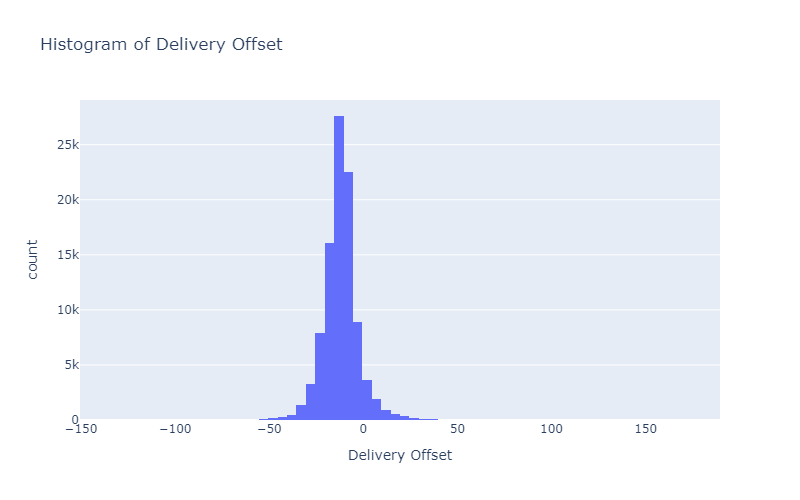

In [17]:
# Identify the distribution of delivery offset using a histogram
fig = px.histogram(
    customer_orders_df,
    x='delivery_offset',
    nbins=100,
    title='Histogram of Delivery Offset',
    labels={
        'count': 'Frequency',
        'delivery_offset': 'Delivery Offset'
    }
)

# Show the plot
image_bytes = fig.to_image(format='png', width=800)
Image(image_bytes)

Notes:
- Outliers will need to be dropped in the delivery offset as there are outliers which are delivered very late and very early, up to 40 days late or 50 days early. Outliers need to be removed in analysis.
- Normal distribution
- Most customers experience delivers about 10 days early.

In [18]:
# Identify the median delivery offset for each unique customer
median_delivery_offset_df = customer_orders_df.groupby('customer_unique_id')[['delivery_offset']].median().reset_index()

# Rename the column to median_delivery_offset
median_delivery_offset_df = median_delivery_offset_df.rename(columns={'delivery_offset': 'median_delivery_offset'})

# Merge with repeated customers dataset to identify repeated customers
median_delivery_offset_df = pd.merge(
    median_delivery_offset_df, 
    repeated_customers_df[['customer_unique_id', 'is_repeated_customer']], 
    on='customer_unique_id', 
    how='left')

# Calculate IQR for the delivery_offset column
Q1 = median_delivery_offset_df['median_delivery_offset'].quantile(0.25)
Q3 = median_delivery_offset_df['median_delivery_offset'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the dataframe to remove outliers
median_delivery_offset_df = median_delivery_offset_df[
    (median_delivery_offset_df['median_delivery_offset'] >= lower_bound) &
    (median_delivery_offset_df['median_delivery_offset'] <= upper_bound)
]


median_delivery_offset_df.head(3)

,customer_unique_id,median_delivery_offset,is_repeated_customer
0,0000366f3b9a7992bf8c76cfdf3221e2,-5.0,False
1,0000b849f77a49e4a4ce2b2a4ca5be3f,-5.0,False
2,0000f46a3911fa3c0805444483337064,-2.0,False


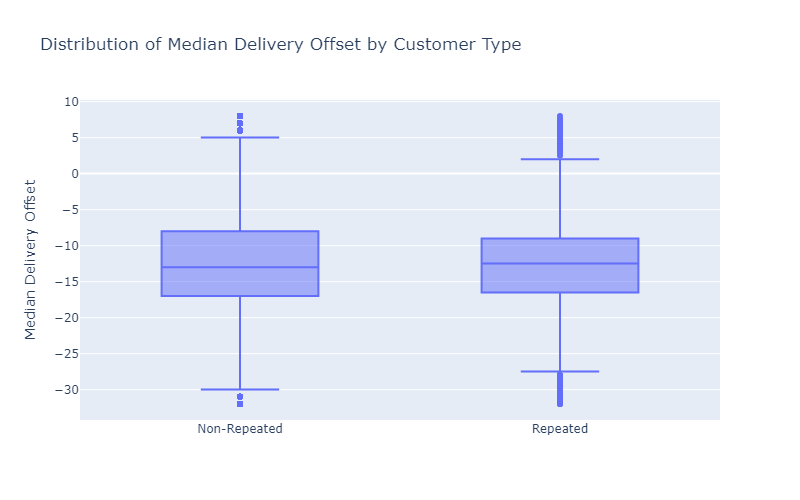

In [19]:
# Create a box plot to show distributions of median delivery offset
fig = px.box(
    median_delivery_offset_df, 
    x='is_repeated_customer', 
    y='median_delivery_offset', 
    title='Distribution of Median Delivery Offset by Customer Type',
    labels={'median_delivery_offset': 'Median Delivery Offset'}
)

# Hide the x-axis and change the category names
fig.update_layout(
    xaxis=dict(
        tickvals=[0, 1],  # Set custom tick values 
        ticktext=['Non-Repeated', 'Repeated'],  # Custom category names
        title=None  # Hide the x-axis title
    )
)

# Show the plot
image_bytes = fig.to_image(format='png', width=800)
Image(image_bytes)

**Findings**:
- Both repeated and non-repeated customers have similar distributions of delivery offsets.
- This suggests that the delivery offset, which indicates how early or late a delivery is, does not significantly influence a customer's likelihood of making a repeat purchase on Olist.
- Surprisingly, this means the efficiency of Olist's delivery process is not a factor that contributes to customers making repeated purchases on Olist.

# Order Size/Quantity
Investigate if incentives for bulk or single product purchases affect customers returning to Olist for repeated purchases.

In [20]:
# Merge customers, orders, and products dataset
customer_orders_products_df = (
    customers_df[['customer_id', 'customer_unique_id']]
    .merge(
        orders_df[['customer_id', 'order_id']], 
        on='customer_id', 
        how='left'
    )
    .merge(
        items_df, 
        on='order_id', 
        how='left'
    )
)

# Drop orders with missing items
customer_orders_products_df.dropna(
    axis=0, 
    inplace=True
)

# Count the number of products in each order for each customer
product_count_df = customer_orders_products_df.groupby(
    ['customer_unique_id', 'order_id']).agg(
    products_count=('order_item_id', 'count')
).reset_index()

# Calculate the median number of products per order for each customer
median_product_count_df = product_count_df.groupby('customer_unique_id').agg(
    median_product_count=('products_count', 'median')
).reset_index()

# Identify the repeated and non-repeated customers
median_product_count_df = median_product_count_df.merge(
    repeated_customers_df[['customer_unique_id', 'is_repeated_customer']], 
    on='customer_unique_id', 
    how='left'
)

median_product_count_df

,customer_unique_id,median_product_count,is_repeated_customer
0,0000366f3b9a7992bf8c76cfdf3221e2,1.0,False
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1.0,False
2,0000f46a3911fa3c0805444483337064,1.0,False
3,0000f6ccb0745a6a4b88665a16c9f078,1.0,False
4,0004aac84e0df4da2b147fca70cf8255,1.0,False
...,...,...,...
95407,fffcf5a5ff07b0908bd4e2dbc735a684,2.0,False
95408,fffea47cd6d3cc0a88bd621562a9d061,1.0,False
95409,ffff371b4d645b6ecea244b27531430a,1.0,False
95410,ffff5962728ec6157033ef9805bacc48,1.0,False


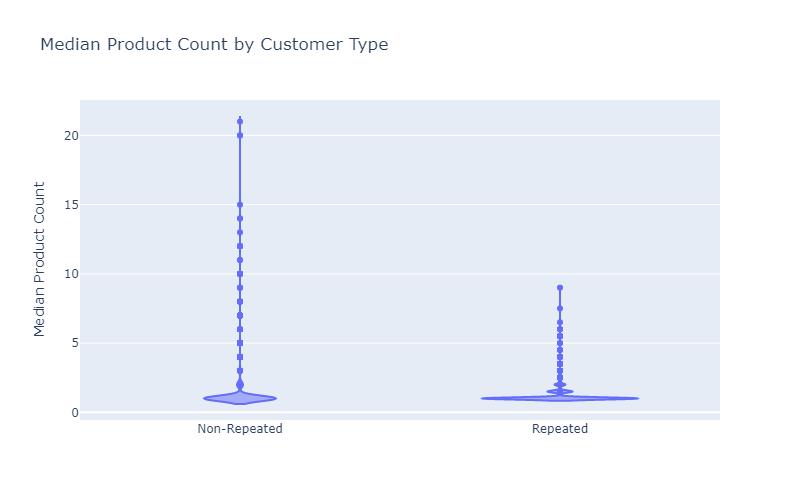

In [21]:
# Create a violin plot to showcase distribution of median product count per order
fig = px.violin(
    median_product_count_df, 
    x='is_repeated_customer', 
    y='median_product_count', 
    title='Median Product Count by Customer Type',
    labels={'median_product_count': 'Median Product Count'}
)

# Hide the x-axis and change the category names
fig.update_layout(
    xaxis=dict(
        tickvals=[0, 1],  # Set custom tick values 
        ticktext=['Non-Repeated', 'Repeated'],  # Custom category names
        title=None  # Hide the x-axis title
    )
)

# Show the plot
image_bytes = fig.to_image(format='png', width=800)
Image(image_bytes)

**Findings**:
- The majority of repeated and non-repeated customers buy only 1 product from Olist in a single order.
- This suggests that Olist is not usually used for bulk orders by both repeat and non-repeated users, rather used for single products.
- This also implies that Olist's repeated customers do not return due to incentives in buying bulk or single products as the distributions of the median number of products in each order is similar, excluding the outliers.

# Order Pricing
Investigates if customers return for cheap or expensive products.

In [22]:
# Calculate the total price and freight_value of each order
order_costs_df = customer_orders_products_df.groupby(
    ['customer_unique_id', 'order_id']).agg(
    order_price=('price', 'sum'),
    order_freight_value=('freight_value', 'sum')
).reset_index()

# Calculate total cost of the order
order_costs_df['total_cost'] = order_costs_df['order_price'] + order_costs_df['order_freight_value']

# Identify the repeated and non-repeated customers
order_costs_df = order_costs_df.merge(
    repeated_customers_df[['customer_unique_id', 'is_repeated_customer']], 
    on='customer_unique_id', 
    how='left'
)

# Calculate IQR for the total_cost column
Q1 = order_costs_df['total_cost'].quantile(0.25)
Q3 = order_costs_df['total_cost'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the dataframe to remove outliers
order_costs_df = order_costs_df[
    (order_costs_df['total_cost'] >= lower_bound) &
    (order_costs_df['total_cost'] <= upper_bound)
]

order_costs_df.head(3)

,customer_unique_id,order_id,order_price,order_freight_value,total_cost,is_repeated_customer
0,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,129.9,12.00,141.90,False
1,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,18.9,8.29,27.19,False
2,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,69.0,17.22,86.22,False


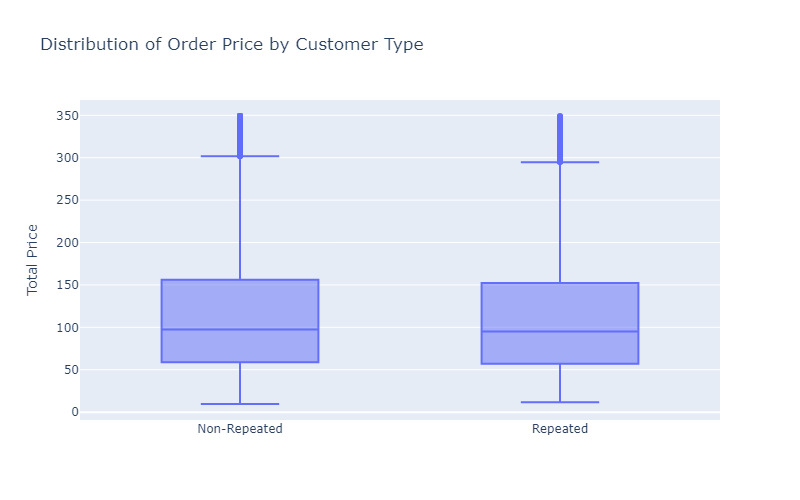

In [23]:
# Create a box plot to show distributions of order_price
fig = px.box(
    order_costs_df, 
    x='is_repeated_customer', 
    y='total_cost', 
    title='Distribution of Order Price by Customer Type',
    labels={'total_cost': 'Total Price'}
)

# Hide the x-axis and change the category names
fig.update_layout(
    xaxis=dict(
        tickvals=[0, 1],  # Set custom tick values 
        ticktext=['Non-Repeated', 'Repeated'],  # Custom category names
        title=None  # Hide the x-axis title
    )
)

# Show the plot
image_bytes = fig.to_image(format='png', width=800)
Image(image_bytes)

**Findings**:
- Both orders by repeated and non-repeated customers have similar distributions.
- This implies that the price of the orders do not influence repeated customers to make repeated purchases in Olist.

# Product
Identify the types of products that returning customers usually look for, such as small or large products.

In [24]:
products_df

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_id,product_category_name
0,40.0,287.0,1.0,225.0,16.0,10.0,14.0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria
1,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,3aa071139cb16b67ca9e5dea641aaa2f,artes
2,46.0,250.0,1.0,154.0,18.0,9.0,15.0,96bd76ec8810374ed1b65e291975717f,esporte_lazer
3,27.0,261.0,1.0,371.0,26.0,4.0,26.0,cef67bcfe19066a932b7673e239eb23d,bebes
4,37.0,402.0,4.0,625.0,20.0,17.0,13.0,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas
...,...,...,...,...,...,...,...,...,...
32945,45.0,67.0,2.0,12300.0,40.0,40.0,40.0,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao
32946,41.0,971.0,1.0,1700.0,16.0,19.0,16.0,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao
32947,50.0,799.0,1.0,1400.0,27.0,7.0,27.0,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho
32948,60.0,156.0,2.0,700.0,31.0,13.0,20.0,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios


In [25]:
# Merge customers, orders, items, and products
customer_orders_items_products_df = (
    customers_df[['customer_id', 'customer_unique_id']]
    .merge(
        orders_df[['customer_id', 'order_id']], 
        on='customer_id', 
        how='left'
    )
    .merge(
        items_df[['order_id', 'product_id']], 
        on='order_id', 
        how='left'
    )
    .merge(
        products_df, 
        on='product_id', 
        how='left'
    )
)

# Drop rows with missing product information
customer_orders_items_products_df.dropna(
    axis=0, 
    inplace=True
)

# Obtain median product_description_lenght for all the products bought by each customer
median_product_description_lenght_df = customer_orders_items_products_df.groupby(
    ['customer_unique_id']).agg(
    median_product_description_lenght=('product_description_lenght', 'median')
).reset_index()

# Identify the repeated and non-repeated customers
median_product_description_lenght_df = median_product_description_lenght_df.merge(
    repeated_customers_df[['customer_unique_id', 'is_repeated_customer']], 
    on='customer_unique_id', 
    how='left'
)
median_product_description_lenght_df

,customer_unique_id,median_product_description_lenght,is_repeated_customer
0,0000366f3b9a7992bf8c76cfdf3221e2,236.0,False
1,0000b849f77a49e4a4ce2b2a4ca5be3f,635.0,False
2,0000f46a3911fa3c0805444483337064,177.0,False
3,0000f6ccb0745a6a4b88665a16c9f078,1741.0,False
4,0004aac84e0df4da2b147fca70cf8255,794.0,False
...,...,...,...
95395,fffcf5a5ff07b0908bd4e2dbc735a684,478.5,False
95396,fffea47cd6d3cc0a88bd621562a9d061,506.0,False
95397,ffff371b4d645b6ecea244b27531430a,716.0,False
95398,ffff5962728ec6157033ef9805bacc48,591.0,False


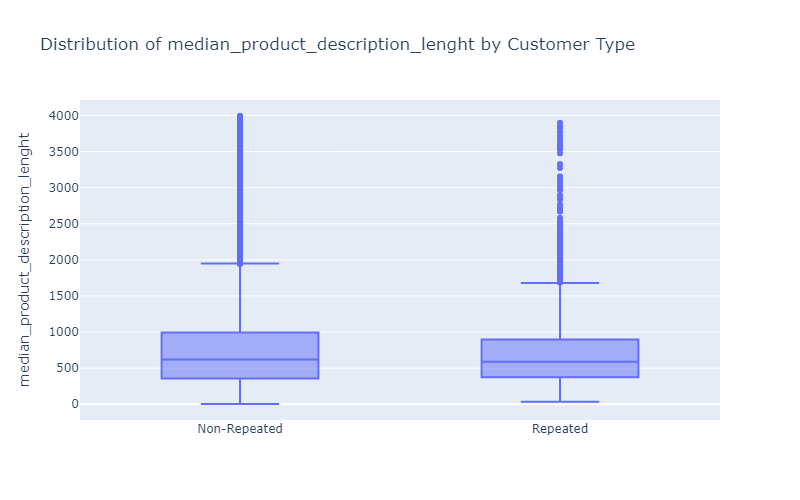

In [26]:
# Create a box plot to show distributions of median_product_description_lenght
fig = px.box(
    median_product_description_lenght_df, 
    x='is_repeated_customer', 
    y='median_product_description_lenght', 
    title='Distribution of median_product_description_lenght by Customer Type'
)

# Hide the x-axis and change the category names
fig.update_layout(
    xaxis=dict(
        tickvals=[0, 1],  # Set custom tick values 
        ticktext=['Non-Repeated', 'Repeated'],  # Custom category names
        title=None  # Hide the x-axis title
    )
)

# Show the plot
image_bytes = fig.to_image(format='png', width=800)
Image(image_bytes)

In [27]:
# Calculate the volume of the product as a cube
customer_orders_items_products_df['volume'] = (
    customer_orders_items_products_df['product_length_cm'] *
    customer_orders_items_products_df['product_height_cm'] *
    customer_orders_items_products_df['product_width_cm']
)

# Obtain median volume for all the products bought by each customer
median_volume_df = customer_orders_items_products_df.groupby(
    ['customer_unique_id']).agg(
    median_volume=('volume', 'median')
).reset_index()

# Identify the repeated and non-repeated customers
median_volume_df = median_volume_df.merge(
    repeated_customers_df[['customer_unique_id', 'is_repeated_customer']], 
    on='customer_unique_id', 
    how='left'
)

# Calculate IQR for the total_cost column
Q1 = median_volume_df['median_volume'].quantile(0.25)
Q3 = median_volume_df['median_volume'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the dataframe to remove outliers
median_volume_df = median_volume_df[
    (median_volume_df['median_volume'] >= lower_bound) &
    (median_volume_df['median_volume'] <= upper_bound)
]

median_volume_df

,customer_unique_id,median_volume,is_repeated_customer
0,0000366f3b9a7992bf8c76cfdf3221e2,7616.0,False
1,0000b849f77a49e4a4ce2b2a4ca5be3f,5148.0,False
3,0000f6ccb0745a6a4b88665a16c9f078,1045.0,False
4,0004aac84e0df4da2b147fca70cf8255,528.0,False
5,0004bd2a26a76fe21f786e4fbd80607f,8241.0,False
...,...,...,...
95394,fffcc512b7dfecaffd80f13614af1d16,1960.0,False
95396,fffea47cd6d3cc0a88bd621562a9d061,32076.0,False
95397,ffff371b4d645b6ecea244b27531430a,3315.0,False
95398,ffff5962728ec6157033ef9805bacc48,4480.0,False


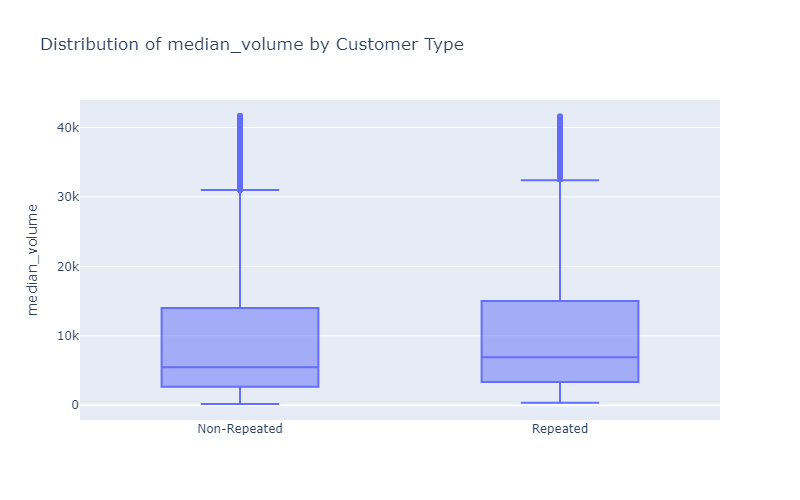

In [28]:
# Create a box plot to show distributions of median_product_description_lenght
fig = px.box(
    median_volume_df, 
    x='is_repeated_customer', 
    y='median_volume', 
    title='Distribution of median_volume by Customer Type'
)

# Hide the x-axis and change the category names
fig.update_layout(
    xaxis=dict(
        tickvals=[0, 1],  # Set custom tick values 
        ticktext=['Non-Repeated', 'Repeated'],  # Custom category names
        title=None  # Hide the x-axis title
    )
)

# Show the plot
image_bytes = fig.to_image(format='png', width=800)
Image(image_bytes)

In [32]:
# Merge customer_orders_items_products_df with repeated_customers
product_categories_df = customer_orders_items_products_df.merge(
    repeated_customers_df[['customer_unique_id', 'is_repeated_customer']],
    on='customer_unique_id', 
    how='left'
)

# Remove products which are missing a product category
product_categories_df = product_categories_df[product_categories_df['product_category_name'] != 'missing']

product_categories_df
  

,customer_id,customer_unique_id,order_id,product_id,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name,volume,is_repeated_customer
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,a9516a079e37a9c9c36b9b78b10169e8,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,moveis_escritorio,107136.0,False
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,4aa6014eceb682077f9dc4bffebc05b0,43.0,1002.0,3.0,10150.0,89.0,15.0,40.0,utilidades_domesticas,53400.0,False
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,bd07b66896d6f1494f5b86251848ced7,55.0,955.0,1.0,8267.0,52.0,52.0,17.0,moveis_escritorio,45968.0,False
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,a5647c44af977b148e0a3a4751a09e2e,48.0,1066.0,1.0,12160.0,56.0,51.0,28.0,moveis_escritorio,79968.0,False
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,9391a573abe00141c56e38d84d7d5b3b,61.0,407.0,1.0,5200.0,45.0,15.0,35.0,casa_conforto,23625.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112620,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,6760e20addcf0121e9d58f2f1ff14298,ccb4503d9d43d245d3b295d0544f988b,51.0,489.0,2.0,611.0,22.0,22.0,23.0,livros_interesse_geral,11132.0,False
112621,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,9ec0c8947d973db4f4e8dcf1fbfa8f1b,9ede6b0570a75a4b9de4f383329f99ee,51.0,1193.0,1.0,1211.0,25.0,24.0,22.0,esporte_lazer,13200.0,False
112622,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,fed4434add09a6f332ea398efd656a5c,7a5d2e1e131a860ae7d18f6fffa9d689,60.0,575.0,1.0,870.0,25.0,20.0,18.0,beleza_saude,9000.0,False
112623,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,e31ec91cea1ecf97797787471f98a8c2,f819f0c84a64f02d3a5606ca95edd272,59.0,452.0,1.0,710.0,19.0,13.0,14.0,relogios_presentes,3458.0,False


In [38]:
product_categories_df[product_categories_df['is_repeated_customer']==True]['product_category_name'].value_counts(normalize=True) * 100

product_category_name
cama_mesa_banho                                  14.914982
moveis_decoracao                                 10.992101
esporte_lazer                                     9.198018
beleza_saude                                      7.591378
informatica_acessorios                            7.390548
                                                   ...    
portateis_casa_forno_e_cafe                       0.013389
portateis_cozinha_e_preparadores_de_alimentos     0.013389
fashion_roupa_infanto_juvenil                     0.013389
artigos_de_festas                                 0.013389
pc_gamer                                          0.013389
Name: proportion, Length: 70, dtype: float64

In [39]:
product_categories_df[product_categories_df['is_repeated_customer']==False]['product_category_name'].value_counts(normalize=True) * 100

product_category_name
cama_mesa_banho                  9.656271
beleza_saude                     8.789225
esporte_lazer                    7.678865
moveis_decoracao                 7.254031
informatica_acessorios           7.023269
                                   ...   
cds_dvds_musicais                0.013517
la_cuisine                       0.011586
pc_gamer                         0.007724
fashion_roupa_infanto_juvenil    0.006759
seguros_e_servicos               0.001931
Name: proportion, Length: 73, dtype: float64

# Customer Satisfaction
Identify a correlation between customer satisfaction and returning customer rate.

In [30]:
# Aggregate reviews by order id to determine their aggregated satisfaction with the order

# Location
Compare the locations of high-value customers to other customers. Identifies the demographic of people who are more likely to buy from Olist.

# Sellers
Identifies if the distance of the seller or their reputation affects customers returning to Olist.